In [46]:
import numpy as np
import networkx as nx
from scipy import stats
import pandas as pd
from pywhy_graphs.viz import draw
from networkx import ancestors
from causalnex.structure import StructureModel
import matplotlib.pyplot as plt

In [47]:
import pandas as pd
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
from causalnex.network import BayesianNetwork as CNBayesianNetwork
import pgmpy.inference.CausalInference as CI
from causalnex.discretiser import Discretiser
from causalnex.inference import InferenceEngine

#### Parameters

In [48]:
n0 = 85
n_bins = 5
graph_file = "adj.csv"

In [49]:
def cn_from_df(df, sm, m, n_bins, mode='cn'):
    ancestor_data = df[m]
    m_nodes = ["n" + str(i) for i in m]
    df = ancestor_data #.iloc[:100, :]
    df.columns = m_nodes
    bin_means = np.zeros((len(df.columns), n_bins))
    for i, col in enumerate(df.columns):
        # df.loc[:, col] = p
        u, bins = pd.cut(df[col], bins=n_bins, labels=False, retbins=True)
        # for i in range(len(bins) - 1):
            # df.loc[u == i, col] = bins[i] + (bins[i + 1] - bins[i]) / 2
        df.loc[:, col] = u
        for b in range(len(bins) - 1):
            bin_means[i, b] = bins[b] + (bins[b + 1] - bins[b]) / 2
    if mode == 'cn':
        cn = CNBayesianNetwork(sm)
        cn = cn.fit_node_states_and_cpds(df)
        ie = InferenceEngine(cn)
        return cn, ie, bin_means
    else:
        bn = BayesianNetwork(sm)
        bn.fit(df)
        return bn

In [50]:
A = np.loadtxt(graph_file, delimiter=",")

# graph creation
df_low = pd.read_csv(f"dataset/low_scrap.csv")
df_high = pd.read_csv(f"dataset/high_scrap.csv")
df = pd.concat([df_low, df_high], axis=0)


stations = df.keys()
stations = [station[7:] for station in stations]

def process_df(df):
    df.columns = [str(i) for i in range(len(stations))]

process_df(df)
G = nx.DiGraph()
G.add_nodes_from(range(len(stations)))
for i in range(len(stations)):
    for j in range(len(stations)):
        if A[i, j] == 1:
            G.add_edge(i, j)

m = list(G.predecessors(n0)) + [n0]
m = [str(i) for i in m]

dag = DAG()
dag.add_node(str(n0))
for a in m:
    for b in m:
        if G.has_edge(int(a), int(b)):
            dag.add_edge(str(a), str(b))

draw(dag)

sm_manual = StructureModel()
for e in dag.edges:
    sm_manual.add_edges_from(
        [
            ("n" + e[0], "n" + e[1])
        ]
    )

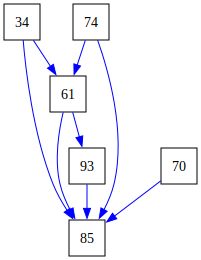

In [51]:
draw(dag)

In [62]:
process_df(df_low)
process_df(df_high)

cn_low, ie_low, bm_low = cn_from_df(df_low, sm_manual, m, n_bins)
cn_high, ie_high, bm_high = cn_from_df(df_high, sm_manual, m, n_bins)
cn, ie, bm = cn_from_df(df, sm_manual, m, n_bins)
m_strings = ['n' + str(i) for i in m]

/var/folders/wr/gb48q8ld1zs6d76c1nzvz68w0000gn/T/ipykernel_4051/2313523576.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = u
/var/folders/wr/gb48q8ld1zs6d76c1nzvz68w0000gn/T/ipykernel_4051/2313523576.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col] = u
/var/folders/wr/gb48q8ld1zs6d76c1nzvz68w0000gn/T/ipykernel_4051/2313523576.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [63]:
def marginals(id, type='hl'):
    if type == 'hl':
        return ie_low.query()[id], ie_high.query()[id]
    else:
        return ie.query()[id]

In [75]:
def marg_plot(id):
    j = m_strings.index(id)
    low, high = marginals(id, 'hl')
    l = np.zeros((2, n_bins))
    for i in range(n_bins):
        l[0, i] = low[i]
        l[1, i] = high[i]
    
    plt.plot(bm_low[j], l[0, :], label='low')
    plt.plot(bm_high[j], l[1, :], label='high')
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("P")
    plt.title(id)
    plt.show()

def joint_marg(id):
    j = m_strings.index(id)
    marg = marginals(id, 'joint')
    l = np.zeros((n_bins))
    for i in range(n_bins):
        l[i] = marg[i]
    
    plt.plot(bm[j], l, label='joint')
    low, high = marginals(id, 'hl')
    l = np.zeros((2, n_bins))
    for i in range(n_bins):
        l[0, i] = low[i]
        l[1, i] = high[i]
    
    plt.plot(bm_low[j], l[0, :], label='low')
    plt.plot(bm_high[j], l[1, :], label='high')
    plt.legend()
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("P")
    plt.title(id)
    plt.show()

In [76]:
for j, m in enumerate(m_strings):
    # print(m)
    low, high = marginals(m)
    p = np.zeros((n_bins, 2))
    x_low = bm_low[j]
    x_high = bm_high[j]
    for i in range(n_bins):
        p[i, 0] = low[i]
        p[i, 1] = high[i]

    # plot p vs x
    fig, ax = plt.subplots()
    # small size
    fig.set_size_inches(5, 5)
    plt.plot(x_low, p[:, 0], label='low')
    plt.plot(x_high, p[:, 1], label='high')



KeyboardInterrupt: 

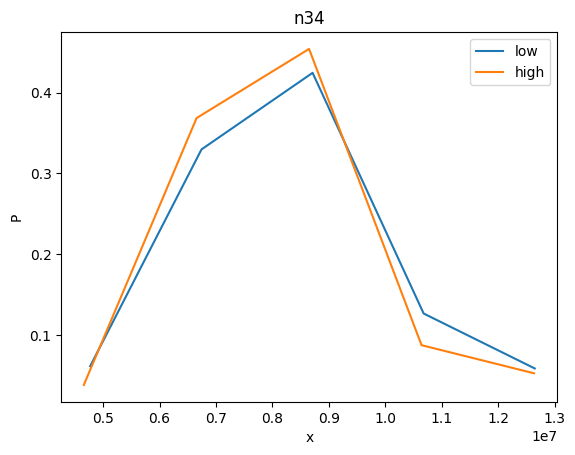

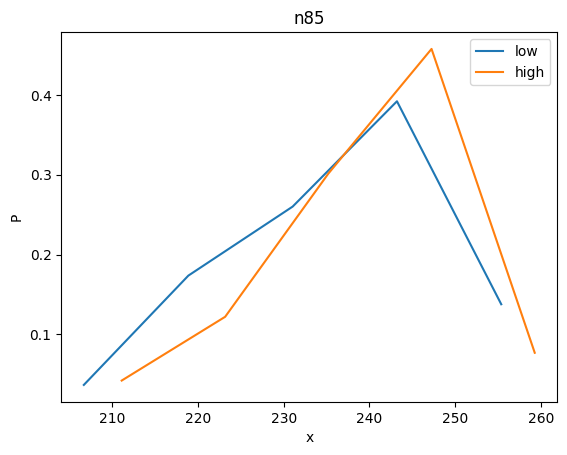

In [77]:
marg_plot('n34')
marg_plot('n85')

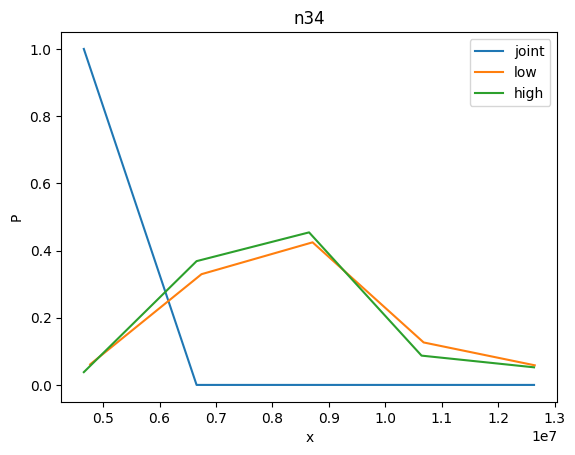

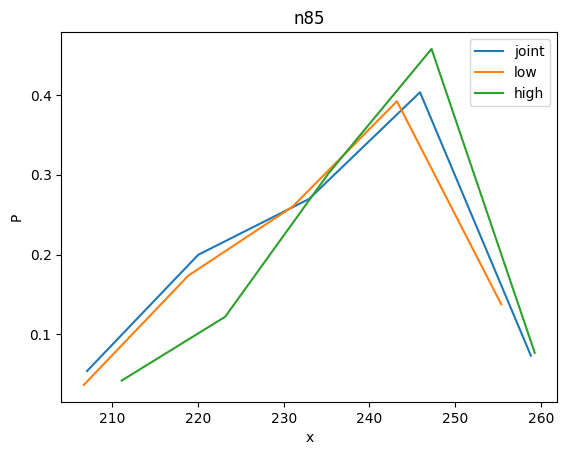

In [78]:
# we fix n34 to its lowest quartile
ie.do_intervention('n34', 0)
joint_marg('n34')
joint_marg('n85')

We see that n34 is fixed to its lowest quartile. The resulting distribution of n85 (joint) has become slightly higher. Therefore, a lowering of n34 is a predictor of a higher n85.